# 机器翻译与数据集
# （例如给一句中文翻译为英文）

语言模型是自然语言处理的关键， 而机器翻译是语言模型最成功的基准测试。

因为机器翻译正是将输入序列转换成输出序列的 序列转换模型（sequence transduction）的核心问题。 

机器翻译（machine translation）指的是 将序列从一种语言自动翻译成另一种语言


In [1]:
import os
import torch
from d2l import torch as d2l

In [2]:
# 设置数据源的 URL 和哈希值以下载法语-英语数据集
# @save 表示在 d2l 库中保存这段代码
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

# @save 表示在 d2l 库中保存这段代码
def read_data_nmt():
    """载入“英语－法语”数据集"""
    
    # 下载并解压数据集，返回数据目录
    data_dir = d2l.download_extract('fra-eng')
    
    # 打开数据集中包含英语和法语文本的文件
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
              encoding='utf-8') as f:
        # 阅读整个文件内容并返回
        return f.read()

# 调用函数读取数据
raw_text = read_data_nmt()

# 打印文本的前 75 个字符以确认加载成功
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [3]:
# 原始文本数据需要经过几个预处理步骤。 
# 例如，我们用空格代替不间断空格（non-breaking space）， 
# 使用小写字母替换大写字母，并在单词和标点符号之间插入空格

# @save 表示在 d2l 库中保存这段代码
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    
    # 定义一个辅助函数，用于检查字符是否需要在前面加上空格
    def no_space(char, prev_char):
        # 如果当前字符是标点符号且前一个字符不是空格，返回 True
        return char in set(',.!?') and prev_char != ' '

    # 替换不间断空格为常规空格，将大写字母转换为小写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    
    # 使用列表推导式，在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    
    # 将处理后的字符列表连接成字符串并返回
    return ''.join(out)

# 调用预处理函数，对原始文本进行处理
text = preprocess_nmt(raw_text)

# 打印处理后的文本的前 80 个字符以确认预处理效果
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [4]:
# 在机器翻译中，我们更喜欢单词级词元化 
# （最先进的模型可能使用更高级的词元化技术）。 
# 下面的函数对前个文本序列对进行词元， 
# 其中每个词元要么是一个词，要么是一个标点符号。 
# 此函数返回两个词元列表：
# 和： 是源语言（这里是英语）第个文本序列的词元列表， 
# 是目标语言（这里是法语）第个文本序列的词元列表。

# @save 表示在 d2l 库中保存这段代码
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据集"""
    
    source, target = [], []  # 初始化两个列表，分别用于存储源语言和目标语言的词元
    
    # 遍历文本的每一行
    for i, line in enumerate(text.split('\n')):
        # 如果设定了示例数量并且当前行数超过该数量，则停止处理
        if num_examples and i >= num_examples:
            break
        
        # 将行按制表符分割成两个部分
        parts = line.split('\t')
        
        # 确保分割后的部分数量为 2（源语言和目标语言）
        if len(parts) == 2:
            # 将源语言的句子转换为词元并添加到 source 列表
            source.append(parts[0].split(' '))
            # 将目标语言的句子转换为词元并添加到 target 列表
            target.append(parts[1].split(' '))
    
    return source, target  # 返回源语言和目标语言的词元列表

# 调用 tokenize_nmt 函数，将处理后的数据存储到 source 和 target 中
source, target = tokenize_nmt(text)

# 打印源语言和目标语言的前 6 个词元，以确认词元化效果
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

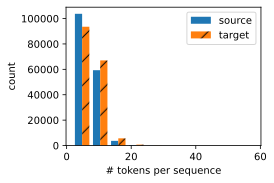

In [5]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

In [6]:
# 使用 d2l.Vocab 类创建源语言（英语）的词汇表
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])


# 假设同一个小批量中的每个序列都应该具有相同的长度， 
# 那么如果文本序列的词元数目少于时， 
# 我们将继续在其末尾添加特定的“<pad>”词元， 直到其长度达到； 
# 反之，我们将截断文本序列时，只取其前 个词元， 并且丢弃剩余的词元。
# 这样，每个文本序列将具有相同的长度， 以便以相同形状的小批量进行加载。
# <pad> 通常用于填充，使得输入序列具有相同的长度；
# <bos> 表示句子的开始；<eos> 表示句子的结束

# 获取词汇表的大小，即词汇表中唯一词元的数量
len(src_vocab)

10012

In [7]:
#@save

#将句子填充或截断  因为需要句子都是固定长度
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [8]:
# @save 表示在 d2l 库中保存这段代码
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    
    # 将每一行的词元转换为其在词汇表中的索引
    lines = [vocab[l] for l in lines]  
    
    # 在每个序列的末尾添加终止符 <eos> 的索引
    lines = [l + [vocab['<eos>']] for l in lines]  
    
    # 将每行词元索引进行截断或填充，并转换为张量
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    
    # 计算每个序列的有效长度（不等于 <pad> 的元素个数）
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    
    return array, valid_len  # 返回张量和有效长度

In [9]:
# @save 表示在 d2l 库中保存这段代码
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    
    # 预处理原始输入文本，准备翻译数据
    text = preprocess_nmt(read_data_nmt())
    
    # 词元化数据，提取源语言和目标语言的句子
    source, target = tokenize_nmt(text, num_examples)
    
    # 创建源语言的词汇表，过滤低频词元，并添加特殊符号
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    
    # 创建目标语言的词汇表，过滤低频词元，并添加特殊符号
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    
    # 将源语言句子转换为张量，并计算每个句子的有效长度
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    
    # 将目标语言句子转换为张量，并计算每个句子的有效长度
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    
    # 将源语言和目标语言的张量以及有效长度打包成一个元组
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    
    # 根据数据数组创建数据迭代器
    data_iter = d2l.load_array(data_arrays, batch_size)
    
    # 返回数据迭代器、源语言词汇表和目标语言词汇表
    return data_iter, src_vocab, tgt_vocab

In [10]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 7, 56,  4,  3,  1,  1,  1,  1],
        [ 6, 73,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[  6,   7,  37,  44,   4,   3,   1,   1],
        [  6,   7, 107,   4,   3,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([6, 5])


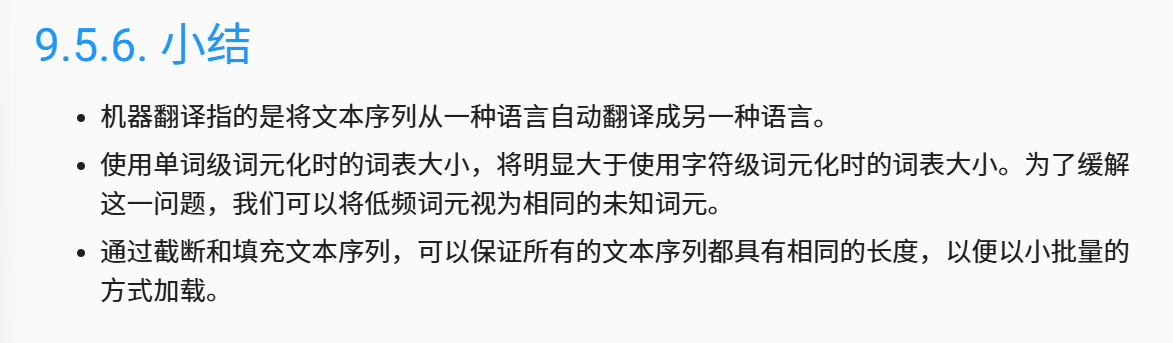